In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
from scipy import stats

from tailrisk import (
    compute_log_returns,
    historical_var, historical_es, fit_normal_params,
    parametric_var_normal, parametric_es_normal,
    parametric_var_t, parametric_es_t,
    fit_gpd_mle, gpd_var_es,
    kupiec_test, christoffersen_test,
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Data loaded successfully:
  - prices shape: (3876,)
  - returns shape: (3875,)
  - returns are in percentage


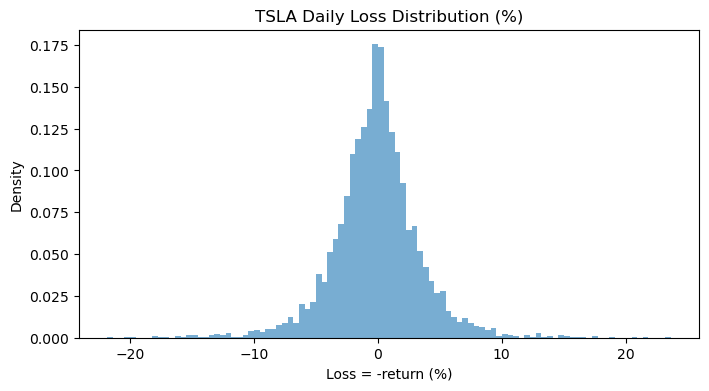

In [6]:
# Load saved data from notebook 01 (returns already in %)
data_path = Path.cwd().parent / "data"
prices = pd.read_csv(data_path / "TSLA_prices.csv", index_col=0, parse_dates=True).squeeze()
rets = pd.read_csv(data_path / "TSLA_returns.csv", index_col=0, parse_dates=True).squeeze()

print(f"Data loaded successfully:")
print(f"  - prices shape: {prices.shape}")
print(f"  - returns shape: {rets.shape}")
print(f"  - returns are in percentage")

losses = -rets  # 损失 = -return (already in %)
losses.name = "TSLA_loss"

plt.figure(figsize=(8, 4))
plt.hist(losses, bins=100, density=True, alpha=0.6)
plt.title("TSLA Daily Loss Distribution (%)")
plt.xlabel("Loss = -return (%)")
plt.ylabel("Density")
plt.show()


In [7]:
for q in [0.90, 0.95, 0.975, 0.99]:
    print(q, losses.quantile(q))

0.9 3.7539076029548597
0.95 5.316310626738578
0.975 7.178020891340002
0.99 9.471315221444971


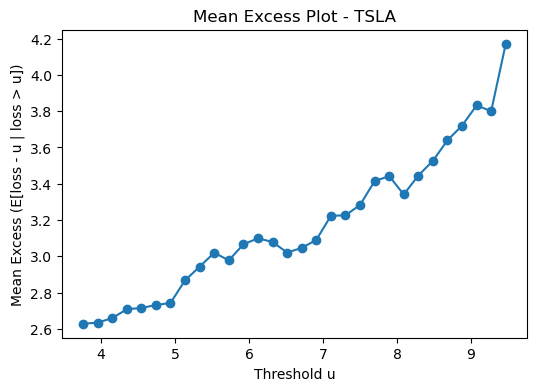

In [8]:
u_grid = np.linspace(losses.quantile(0.90), losses.quantile(0.99), 30)
mean_excess = []

for uu in u_grid:
    exceed = losses[losses > uu]
    mean_excess.append((exceed - uu).mean())

plt.figure(figsize=(6, 4))
plt.plot(u_grid, mean_excess, marker="o")
plt.xlabel("Threshold u")
plt.ylabel("Mean Excess (E[loss - u | loss > u])")
plt.title("Mean Excess Plot - TSLA")
plt.show()


In [10]:
u = float(losses.quantile(0.975))
gpd_params = fit_gpd_mle(rets.values, u=u)
gpd_params


GPDParams(xi=0.12795014640074726, beta=2.8152141550744387, u=7.178020891340002, p_exceed=0.02503225806451613)

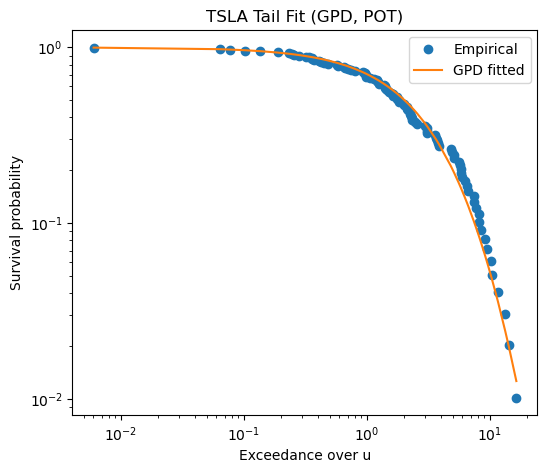

In [11]:
from scipy.stats import genpareto

losses = -rets
exceed = losses[losses > u] - u
exceed_sorted = np.sort(exceed)

# empirical survival
n = len(exceed_sorted)
emp_survival = np.arange(1, n + 1)[::-1] / (n + 1)

# fitted GPD survival
xi, beta, p = gpd_params.xi, gpd_params.beta, gpd_params.p_exceed
# 对 exceed 部分，标准 GPD 的 survival:
fitted_survival = genpareto.sf(exceed_sorted, c=xi, scale=beta)

plt.figure(figsize=(6, 5))
plt.loglog(exceed_sorted, emp_survival, "o", label="Empirical")
plt.loglog(exceed_sorted, fitted_survival, "-", label="GPD fitted")
plt.xlabel("Exceedance over u")
plt.ylabel("Survival probability")
plt.title("TSLA Tail Fit (GPD, POT)")
plt.legend()
plt.show()
